In [7]:
cd My\ Drive

/content/drive/My Drive


In [8]:
cd Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [9]:
from fastai.vision import *

In [94]:
folder = 'black'
file = 'urls_black.csv'

In [91]:
folder = 'grizzly'
file = 'urls_grizzly.csv'

In [98]:
folder = 'teddy'
file = 'urls_teddy.csv'

In [99]:
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents = True, exist_ok = True)

In [100]:
path.ls()

[PosixPath('data/bears/teddy'),
 PosixPath('data/bears/grizzly'),
 PosixPath('data/bears/black'),
 PosixPath('data/bears/urls_grizzly.csv'),
 PosixPath('data/bears/urls_teddy.csv'),
 PosixPath('data/bears/urls_black.csv')]

In [101]:
classes = ['teddy','grizzly','black']

In [102]:
download_images(path/file,dest,max_pics = 200)

In [103]:
for c in classes:
  print(c)
  verify_images(path/c,delete=True,max_size=500)

teddy


grizzly


black


In [106]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [107]:
data.classes

['black', 'grizzly', 'teddy']

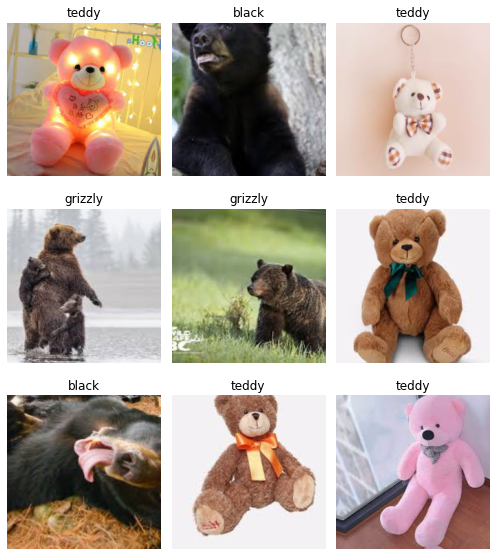

In [108]:
data.show_batch(rows=3,figsize=(7,8))

In [109]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddy'], 3, 68, 16)

In [110]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [111]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.302312,3.899187,0.625000,00:26
1,1.993378,0.282355,0.187500,00:29
2,1.408660,0.014342,0.000000,00:27
3,1.091149,0.005865,0.000000,00:27


In [112]:
learn.save('stage-1')

In [113]:
learn.unfreeze()

In [114]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


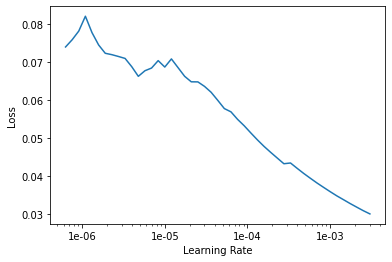

In [115]:
learn.recorder.plot()

In [116]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.069691,0.006215,0.000000,00:41
1,0.108058,0.004314,0.000000,00:38


In [117]:
learn.save('stage-2')

In [118]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (68 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
teddy,teddy,teddy,teddy,teddy
Path: data/bears;

Valid: LabelList (16 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
black,teddy,black,teddy,teddy
Path: data/bears;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [125]:
interp = ClassificationInterpretation.from_learner(learn)

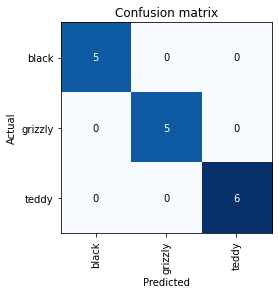

In [126]:
interp.plot_confusion_matrix()

In [127]:
from fastai.widgets import *

In [134]:
learn_cln=cnn_learner(db,models.resnet34,metrics=error_rate)
learn_cln.load('stage-2');

In [136]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [137]:
ImageCleaner(ds,idxs,path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [138]:
ds,idxs=DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [139]:
ImageCleaner(ds,idxs,path,duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [140]:
learn.export()

In [142]:
defaults.device = torch.device('cpu')

In [149]:
img = open_image(path/'black','00000021.jpg')
img

IsADirectoryError: ignored

In [144]:
learn = load_learner(path)

In [146]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

NameError: ignored

In [154]:
!pip install starlette

!pip install uvicorn

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 3.9MB 4.4MB/s 
     |████████████████████████████████| 225kB 23.2MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 


In [155]:
from starlette.applications import Starlette
from starlette.responses import JSONResponse
from starlette.routing import Route


async def homepage(request):
    return JSONResponse({'hello': 'world'})


app = Starlette(debug=True, routes=[
    Route('/', homepage),
])

In [161]:
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })

In [163]:
!uvicorn classify-url:app


ERROR:    Error loading ASGI app. Could not import module "classify-url".
